# **US STATES RANKING OF NATIONAL PARK ACCESSIBILITY**

## Authors: Richard Owusu-Ansah & Maya O'Brien
### Geog 6308 | Fall 2024

In [1]:
# Importing Modules

import arcpy
import plotly
import seaborn as sns
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [116]:
# Setting the environment workspace
arcpy.env.workspace = '.\Data\FinalProject_Geog6308.gdb'
arcpy.env.overwriteOutput = True

In [5]:
# Setting variables for input data

parks = 'NationalParkServiceLands'
states = 'States_2024'
counties = 'Counties_2024'
pop_table = 'Demographics'

In [6]:
# Project parks to match states/counties projection

parks_proj = arcpy.management.Project(in_dataset=parks, out_dataset='parks_proj', out_coor_system=(arcpy.SpatialReference(4269)))

In [9]:
# Join demographics pop table to county boundaries and remove any null values for analysis
counties_fl = arcpy.management.MakeFeatureLayer(in_features=counties, out_layer='counties_fl')
counties_fl_join = arcpy.management.AddJoin(in_layer_or_view=counties_fl, in_field='GEOIDFQ', join_table=pop_table, join_field='GEO_ID')
arcpy.management.SelectLayerByAttribute(in_layer_or_view=counties_fl_join,selection_type='NEW_SELECTION', where_clause="Demographics.GEO_ID IS NOT NULL")
arcpy.management.CopyFeatures(in_features=counties_fl_join,out_feature_class='counties_pop')


<Result '.\\Data\\FinalProject_Geog6308.gdb\\counties_pop'>

In [10]:
# The demographic fields of interest were originally set as text, so here we create new integer fields and populate them with the values from the text fields

text_field1 = "Demographics_DP1_0001C"
integer_field1 = "Demographics_DP1_0001C_int"
text_field2 = "Demographics_DP1_0078C"
integer_field2 = "Demographics_DP1_0078C_int"
text_field3 = "Demographics_DP1_0079C"
integer_field3 = "Demographics_DP1_0079C_int"



arcpy.management.AddFields(in_table="counties_pop",
                           field_description=[[integer_field1, "LONG"], [integer_field2, "LONG"], [integer_field3, "LONG"]])


with arcpy.da.UpdateCursor(in_table="counties_pop",
                           field_names=[text_field1, integer_field1, text_field2, integer_field2, text_field3, integer_field3]) as cursor:
    for row in cursor:
        row[1] = int(row[0])
        row[3] = int(row[2])
        row[5] = int(row[4])
        cursor.updateRow(row)

In [11]:
# Selecting counties that are within 50 miles of a national park

parks_counties_50= arcpy.management.SelectLayerByLocation(in_layer= "counties_pop",
                                       overlap_type= "WITHIN A DISTANCE",
                                       select_features=parks_proj,
                                       search_distance= "50 Miles",
                                       selection_type= "NEW SELECTION")

In [12]:
# Exporting the above selection to a new feature class

arcpy.management.CopyFeatures(in_features=parks_counties_50,
                              out_feature_class='parks_counties_50_fc')

<Result '.\\Data\\FinalProject_Geog6308.gdb\\parks_counties_50_fc'>

# We will calculate the following statistics in the next few cells
- Total population by state
- Total population of white by state
- Total population of black by state
- Total population in accessible counties by state
- Total population of white in accessible counties by state
- Total population of black in accessible counties by state
- Percentage of population in accessible counties by state
- Percentage of white population in accessible counties by total white population by state
- Percentage of black population in accessible counties by total black population by state

In [117]:
# Calculating statistics to find the total popultion, total white population, and total black population by state

arcpy.analysis.Statistics(
    in_table="counties_pop",
    out_table="counties_pop_stats",
    statistics_fields="Demographics_DP1_0001C_int SUM;Demographics_DP1_0078C_int SUM;Demographics_DP1_0079C_int SUM",
    case_field="Counties_2024_STATEFP",
    concatenation_separator=""
)

# Calculating statistics to find the total popultion, total white population, and total black population by state within counties that have access to national parks

arcpy.analysis.Statistics(
    in_table="parks_counties_50_fc",
    out_table="parks_counties_50_stats",
    statistics_fields="Demographics_DP1_0001C_int SUM;Demographics_DP1_0078C_int SUM;Demographics_DP1_0079C_int SUM",
    case_field="Counties_2024_STATEFP",
    concatenation_separator=""
)

<Result '.\\Data\\FinalProject_Geog6308.gdb\\parks_counties_50_stats'>

In [118]:
# Join total state statistics to accessible statitistics so they are in one table

arcpy.management.JoinField(
    in_data="parks_counties_50_stats",
    in_field="Counties_2024_STATEFP",
    join_table="counties_pop_stats",
    join_field="Counties_2024_STATEFP"
)

<Result '.\\Data\\FinalProject_Geog6308.gdb\\parks_counties_50_stats'>

In [119]:
# Join state name to accessibility table

arcpy.management.JoinField(
    in_data="parks_counties_50_stats",
    in_field="Counties_2024_STATEFP",
    join_table="States_2024",
    join_field="STATEFP",
    fields="NAME"
)

<Result '.\\Data\\FinalProject_Geog6308.gdb\\parks_counties_50_stats'>

In [120]:
# Adding additional fields to be calculated below for analysis

arcpy.management.AddFields(in_table="parks_counties_50_stats",
                           field_description=[["Percent_Total_Access", "DOUBLE"], ["Percent_Total_White", "DOUBLE"], ["Percent_Total_Black", "DOUBLE"], ["Diff_Black_White", "DOUBLE"]])

<Result '.\\Data\\FinalProject_Geog6308.gdb\\parks_counties_50_stats'>

In [121]:
# Calculating the statistics for total park access, total park access for the white population, total park access for the black population

fields = ["SUM_Demographics_DP1_0001C_int_1",
          "SUM_Demographics_DP1_0078C_int_1",
          "SUM_Demographics_DP1_0079C_int_1",
          "SUM_Demographics_DP1_0001C_int",
          "SUM_Demographics_DP1_0078C_int",
          "SUM_Demographics_DP1_0079C_int",
          "Percent_Total_Access",
          "Percent_Total_White",
          "Percent_Total_Black",
          "Diff_Black_White"]

with arcpy.da.UpdateCursor(in_table="parks_counties_50_stats", field_names=fields) as cursor:
    for row in cursor:
        row[6] = float((row[3]/row[0])*100)
        row[7] = float((row[4]/row[1])*100)
        row[8] = float((row[5]/row[2])*100)
        row[9] = float(row[7]-row[8])
        cursor.updateRow(row)

In [122]:
# Exporting analysis results to a CSV and updating the environment workspace to the folder containing the CSV

arcpy.env.workspace = '.\Data'
arcpy.env.overwriteOutput = True

arcpy.conversion.ExportTable(
    in_table="FinalProject_Geog6308.gdb\parks_counties_50_stats",
    out_table="summary_table.csv"
)

<Result '.\\Data\\summary_table.csv'>

In [123]:
# Creating a dataframe of the CSV

summary_table = pd.read_csv('.\Data\summary_table.csv')
df = pd.DataFrame(summary_table)
df.rename(columns={"NAME": "State_Name",
                   "SUM_Demographics_DP1_0001C_int_1": "Total_Pop",
                   "SUM_Demographics_DP1_0078C_int_1": "Total_Pop_White",
                   "SUM_Demographics_DP1_0079C_int_1": "Total_Pop_Black",
                   "SUM_Demographics_DP1_0001C_int": "Total_Pop_Access",
                   "SUM_Demographics_DP1_0078C_int": "Total_Pop_Access_White",
                   "SUM_Demographics_DP1_0079C_int": "Total_Pop_Access_Black"})

,Counties_2024_STATEFP,FREQUENCY,Total_Pop_Access,Total_Pop_Access_White,Total_Pop_Access_Black,Counties_2024_STATEFP_1,FREQUENCY_1,Total_Pop,Total_Pop_White,Total_Pop_Black,State_Name,Percent_Total_Access,Percent_Total_White,Percent_Total_Black,Diff_Black_White
0,1,54,4549273.0,2920068.0,1168990.0,1,67,5024279.0,3220452.0,1296162.0,Alabama,90.545788,90.672614,90.188572,0.484042
1,2,24,694565.0,418897.0,21449.0,2,30,733391.0,435392.0,21898.0,Alaska,94.705962,96.211460,97.949584,-1.738124
2,4,15,7151502.0,4322337.0,339150.0,4,15,7151502.0,4322337.0,339150.0,Arizona,100.000000,100.000000,100.000000,0.000000
3,5,66,2720794.0,1929550.0,371768.0,5,75,3011524.0,2114512.0,453783.0,Arkansas,90.346084,91.252733,81.926383,9.326350
4,6,52,38824960.0,15816465.0,2224455.0,6,58,39538223.0,16296122.0,2237044.0,California,98.196017,97.056619,99.437248,-2.380630
5,8,58,5701336.0,4029253.0,233010.0,8,64,5773714.0,4082927.0,234828.0,Colorado,98.746422,98.685404,99.225816,-0.540412
6,10,3,989948.0,597763.0,218899.0,10,3,989948.0,597763.0,218899.0,Delaware,100.000000,100.000000,100.000000,0.000000
7,11,1,689545.0,273194.0,285810.0,11,1,689545.0,273194.0,285810.0,District of Columbia,100.000000,100.000000,100.000000,0.000000
8,12,42,19458774.0,10995483.0,2903394.0,12,67,21538187.0,12422961.0,3246381.0,Florida,90.345459,88.509358,89.434789,-0.925431
9,13,123,10003206.0,5138228.0,3103782.0,13,159,10711908.0,5555483.0,3320513.0,Georgia,93.383980,92.489312,93.472966,-0.983654


In [138]:
# Nationa l Parks Accessibilty By State ranking from the highest to the lowest
national_parks_access_rank = summary_table.nsmallest(51, 'Percent_Total_Access')[['NAME', 'Percent_Total_Access']]
national_parks_access_rank

,NAME,Percent_Total_Access
35,Oklahoma,30.635738
13,Indiana,40.550242
14,Iowa,44.181943
33,North Dakota,44.544689
48,Wisconsin,46.460621
11,Idaho,48.368773
42,Texas,57.050739
15,Kansas,67.547960
32,North Carolina,74.674684
21,Michigan,76.480796


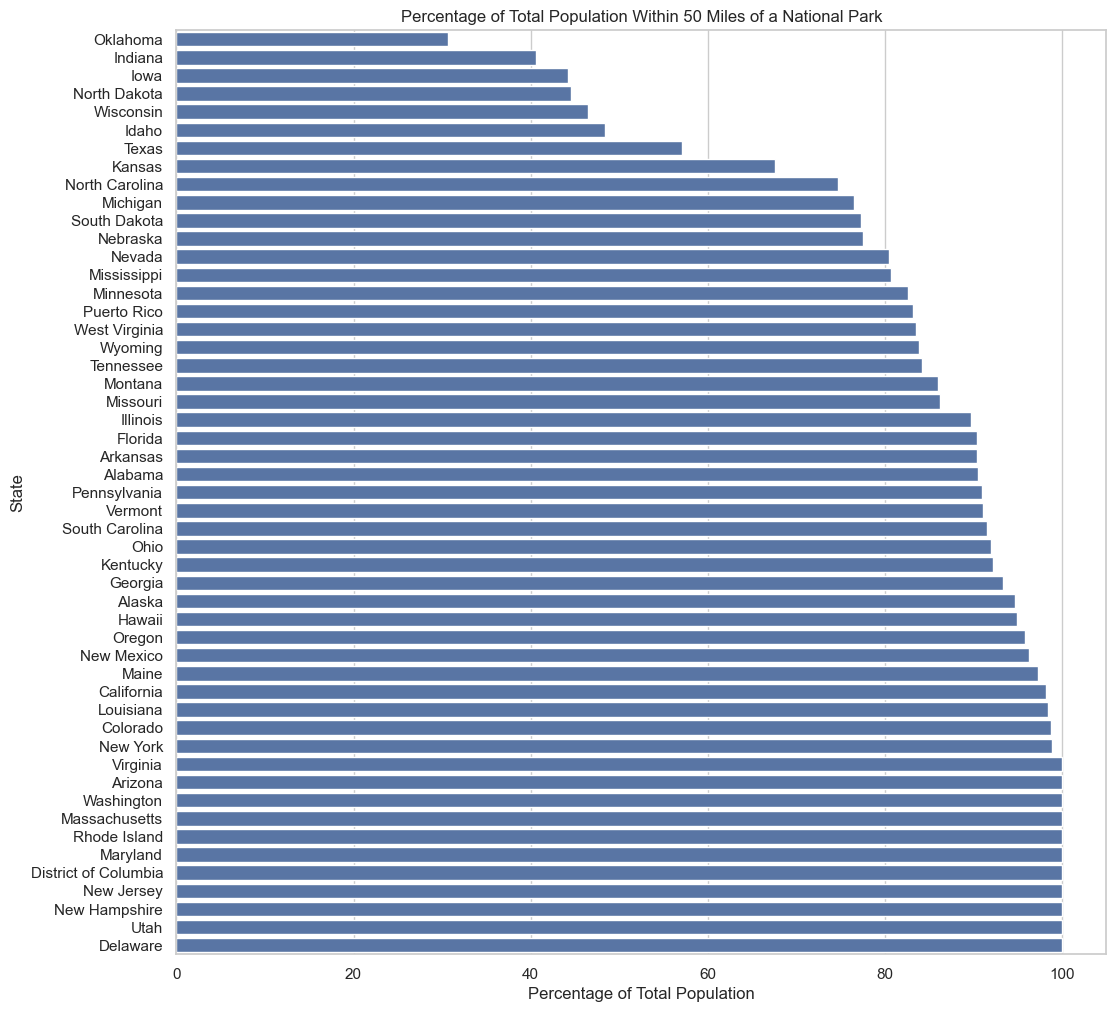

In [139]:
# Bar Plot Showing states and the percent of their population that are within 50 Miles of A National Park
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,12))
sns.barplot(x='Percent_Total_Access', y='NAME', data=national_parks_access_rank)
plt.title('Percentage of Total Population Within 50 Miles of a National Park')
plt.xlabel('Percentage of Total Population')
plt.ylabel('State')
plt.show()

In [141]:
# Percentage of Black Population within 50 Miles of a National Park
percent_black=summary_table.nsmallest(51, 'Percent_Total_Black')[['NAME', 'Percent_Total_Black']]

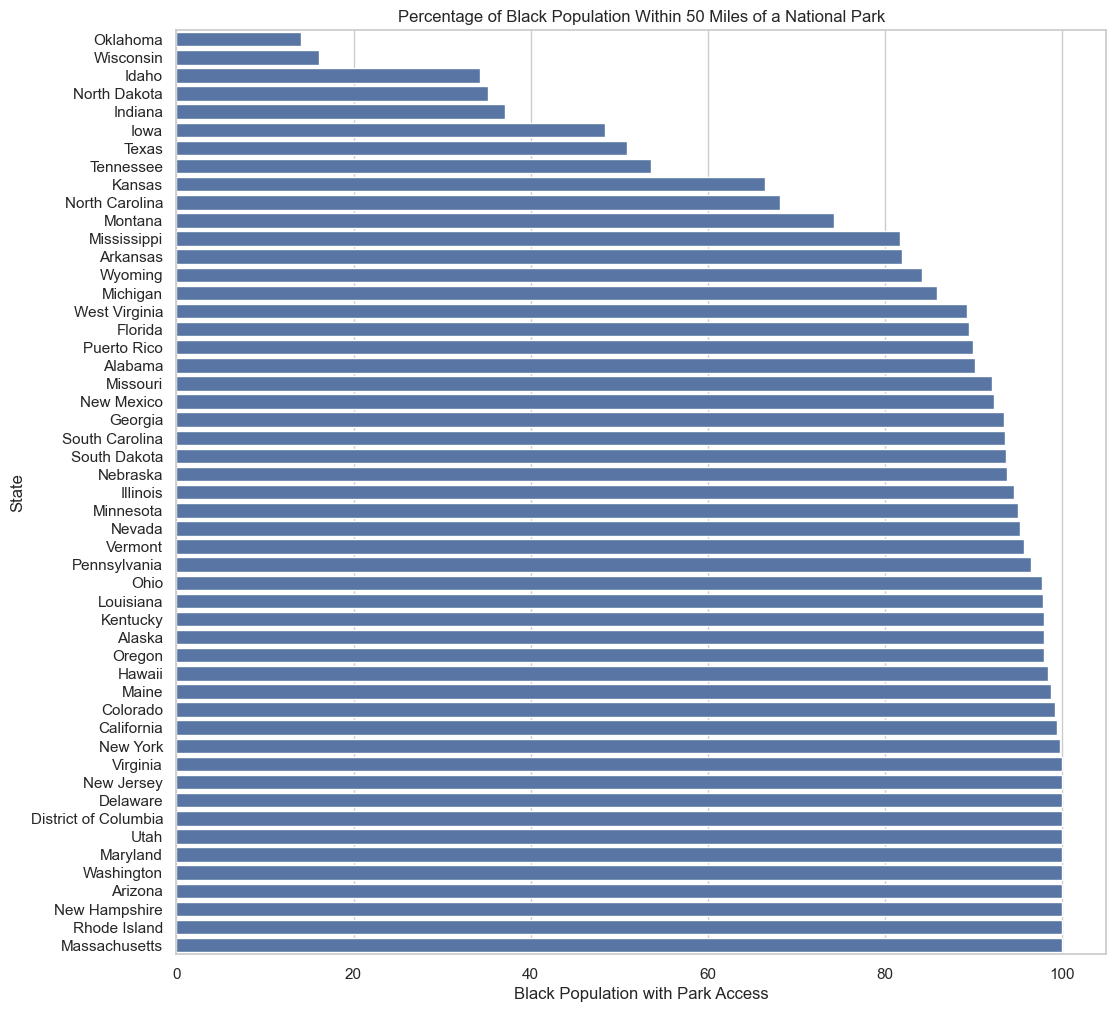

In [143]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,12))
sns.barplot(x='Percent_Total_Black', y='NAME', data=percent_black)
plt.title('Percentage of Black Population Within 50 Miles of a National Park')
plt.xlabel('Black Population with Park Access')
plt.ylabel('State')
plt.show()

In [130]:
# Finding the difference in access between white and black populations

diff = summary_table.nsmallest(51, 'Diff_Black_White')[['NAME', 'Diff_Black_White']]

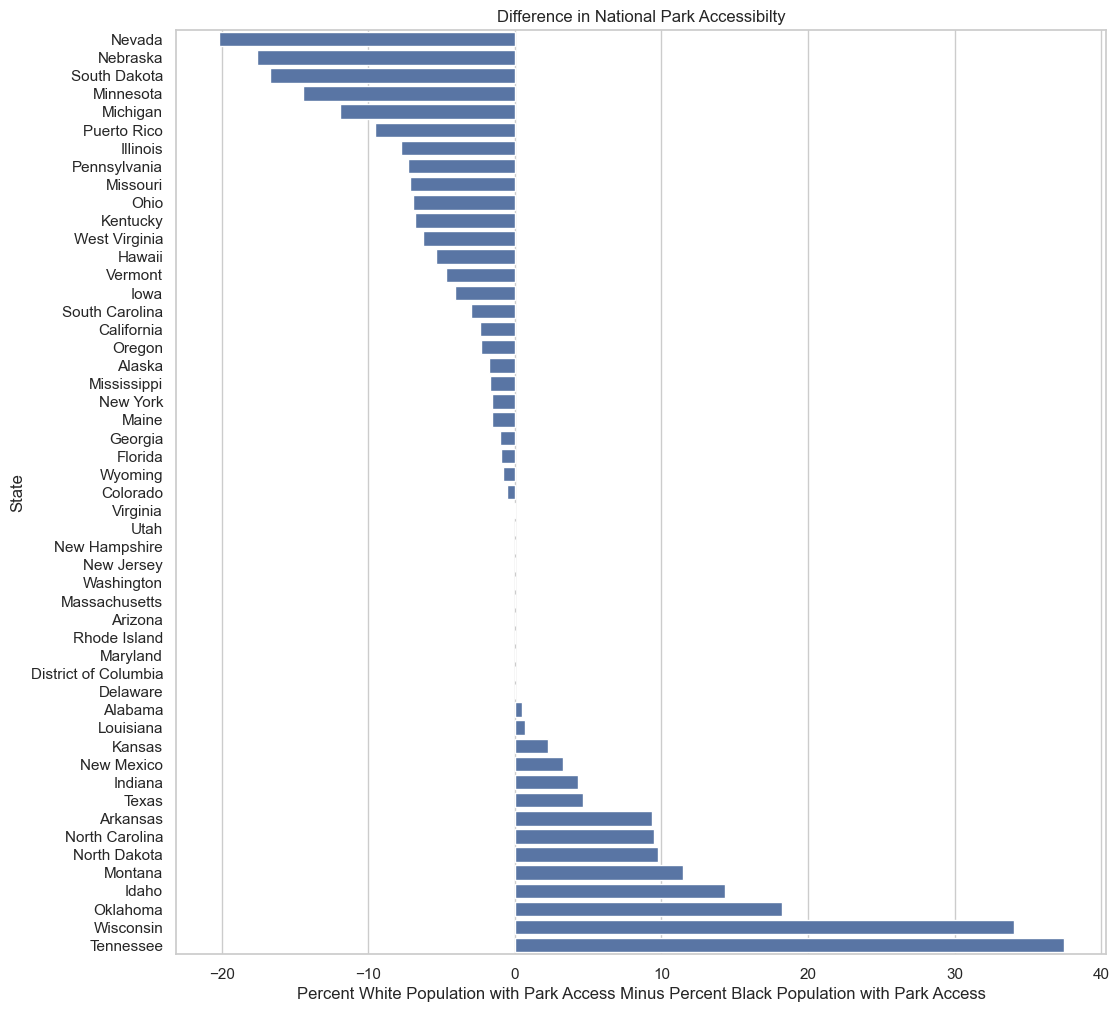

In [133]:
# Bar plot showing difference in access between white and black populations

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,12))
sns.barplot(x='Diff_Black_White', y='NAME', data=diff)
plt.title('Difference in National Park Accessibilty')
plt.xlabel('Percent White Population with Park Access Minus Percent Black Population with Park Access')
plt.ylabel('State')
plt.show()